In [1]:
# https://stackoverflow.com/questions/51501074/implementing-mclp-in-pulp
# 코드는 이 곳을 참조했습니다. 

In [2]:
import numpy as np
import pandas as pd
from pulp import *

In [3]:
# 데이터 가져오기

files = []

for i in os.listdir():
    if i.endswith('.xlsx'):
        files.append(i)
        
files

['좌표_최종_용신동.xlsx',
 'Distance_Matrix.xlsx',
 '용신동 공공시설.xlsx',
 'Test_Distance_Matrix.xlsx']

In [4]:
d = pd.read_excel(files[1]).iloc[:, 1:8] # distance matrix, 가장 앞에 필요없는 index 칼럼만 제거
a = pd.read_excel(files[0]).iloc[:, 0] # 택배 착지량이 있는 칼럼만 선택

In [5]:
# 문자열 -> km 단위의 실수형으로 변환

for j in range(d.shape[1]):
    for i in range(d.shape[0]):
        d.iloc[i, j] = d.iloc[i, j].replace(' km', '')
    d.iloc[:, j] = d.iloc[:, j].astype(float)
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   동대문구청             342 non-null    float64
 1   용신동 주민센터          342 non-null    float64
 2   신설동 공영주차장         342 non-null    float64
 3   청계8노상공영주차장        342 non-null    float64
 4   용두동 청계 노상 공영 주차장  342 non-null    float64
 5   서울특별시교육청 동대문도서관   342 non-null    float64
 6   용두 어린이 영어 도서관     342 non-null    float64
dtypes: float64(7)
memory usage: 18.8 KB


In [6]:
# pulp 패키지가 np.array를 사용해서 pd.DataFrame -> np.array

d = d.values
a = a.values

In [7]:
I = [i for i in range(d.shape[0])] # 수요지 index array
J = [j for j in range(d.shape[1])] # 후보지 index array
S = 0.5 # 최대 커버 지역 500m 설정

P = 1 # 택배함 수

# Compute the sets Ni
# NB: this will be a list in which each item is a list of nodes
# within the threshold distance of the i'th node
N = [[j for j in J if d[i][j] < S] for i in I] # 정확히는 잘 모르겠음

In [8]:
# 문제 구성
prob = LpProblem("MCLP", LpMaximize)

# 결정 변수
x = LpVariable.dicts("x", J, cat = 'Binary') # 후보지
y = LpVariable.dicts("y", I, cat = 'Binary') # 수요지

# 목적함수
prob += lpSum([a[i] * y[i] for i in I])

# 제약식
for i in I:
    prob += lpSum([x[j] for j in N[i]]) >= y[i]

prob += lpSum([x[j] for j in J]) == P

# Solve problem
prob.solve()

x_soln = np.array([x[j].varValue for j in J])

# And print some output
print (("Status:"), LpStatus[prob.status])
print ("Population Served is = ", value(prob.objective))
print ("x = ", x_soln)

Status: Optimal
Population Served is =  121611408.0
x =  [0. 1. 0. 0. 0. 0. 0.]


In [10]:
# 택배함 수 변화 시키면서 반복

answers = []
zs = []

for num_of_fac in range(1, 8):

    prob = LpProblem("MCLP", LpMaximize)
    x = LpVariable.dicts("x", J, cat = 'Binary')
    y = LpVariable.dicts("y", I, cat = 'Binary')

    prob += lpSum([a[i] * y[i] for i in I])

    for i in I:
        prob += lpSum([x[j] for j in N[i]]) >= y[i]

    prob += lpSum([x[j] for j in J]) == num_of_fac

    prob.solve()

    x_soln = np.array([x[j].varValue for j in J])

    print (("Status:"), LpStatus[prob.status])
    print ("Population Served is = ", value(prob.objective))
    print ("x = ", x_soln)
    answers.append(x_soln)
    zs.append(value(prob.objective))

Status: Optimal
Population Served is =  121611408.0
x =  [0. 1. 0. 0. 0. 0. 0.]
Status: Optimal
Population Served is =  177504085.0
x =  [0. 1. 0. 0. 0. 0. 1.]
Status: Optimal
Population Served is =  182370392.0
x =  [0. 1. 0. 0. 0. 1. 1.]
Status: Optimal
Population Served is =  182370392.0
x =  [1. 1. 0. 0. 0. 1. 1.]
Status: Optimal
Population Served is =  182370392.0
x =  [1. 1. 1. 0. 0. 1. 1.]
Status: Optimal
Population Served is =  182370392.0
x =  [1. 1. 0. 1. 1. 1. 1.]
Status: Optimal
Population Served is =  182370392.0
x =  [1. 1. 1. 1. 1. 1. 1.]


In [11]:
import matplotlib.pyplot as plt

In [12]:
plt.figure(figsize = (7,4))

<Figure size 504x288 with 0 Axes>

<Figure size 504x288 with 0 Axes>

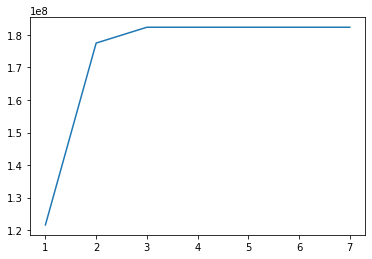

In [14]:
plt.plot(range(1,8), zs)